## Setup

### Install Packages

In [40]:
%%capture

import sys

!{sys.executable} -m pip install stix2
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install html2text
!{sys.executable} -m pip install wordcloud

### Download ThaiCert Dataset

In [41]:
import requests
import json
from os.path import exists

thaicert_database_path = './database/thaicert.json' 

if(exists(thaicert_database_path) == False):

    url_thaicert = "https://apt.thaicert.or.th/cgi-bin/getcard.cgi?g=all&o=j"
    http_req = requests.get(url_thaicert).json()

    with open(thaicert_database_path, 'w+') as output:
        output.write(json.dumps(http_req, indent=2))
        print("\n[+] Database Saved !")



### Establish a connection to MITRE ATT&CK Dataset

In [42]:
from stix2 import MemoryStore

def get_data_from_branch(domain):
    """get the ATT&CK STIX data from MITRE/CTI. Domain should be 'enterprise-attack', 'mobile-attack' or 'ics-attack'. Branch should typically be master."""
    stix_json = requests.get(f"https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/{domain}/{domain}.json").json()
    return MemoryStore(stix_data=stix_json["objects"])

src = get_data_from_branch("enterprise-attack")

print("[+] Connected to ATT&CK STIX!")

[+] Connected to ATT&CK STIX!


## Search Datasets

### Input APT Name

In [43]:
search_apt = input()

Emissary Panda


### Query ThaiCert for Given APT

In [44]:
print("Actor:")
!cat database/thaicert.json | jq '.values[] | select(.names[].name=="'"$search_apt"'") | .actor'
print()

print("Other Names:")
!cat database/thaicert.json | jq '.values[] | select(.names[].name=="'"$search_apt"'") | .names[].name'
print()

print("Country:")
!cat database/thaicert.json | jq '.values[] | select(.names[].name=="'"$search_apt"'") | .country[]'
print()


print("Description:")
!cat database/thaicert.json | jq -r '.values[] | select(.names[].name=="'"$search_apt"'") | .description'
print()


print("Tools:")
!cat database/thaicert.json | jq '.values[] | select(.names[].name=="'"$search_apt"'") | .tools[]'
print()


print("OSINT Links:")
links = !cat database/thaicert.json | jq '.values[] | select(.names[].name=="'"$search_apt"'") | .information[]'
links_cleaned = []
for link in links:
    link_cleaned = link.replace('"', '')
    print(link_cleaned)
    links_cleaned.append(link_cleaned)

Actor:
"Emissary Panda, APT 27, LuckyMouse, Bronze Union"

Other Names:
"Emissary Panda"
"APT 27"
"LuckyMouse"
"Bronze Union"
"TG-3390"
"TEMP.Hippo"
"Budworm"
"Group 35"
"ATK 15"
"Iron Tiger"
"Earth Smilodon"
"ZipToken"

Country:
"China"

Description:
Threat Group-3390 is a Chinese threat group that has extensively used strategic Web compromises to target victims. The group has been active since at least 2010 and has targeted organizations in the aerospace, government, defense, technology, energy, and manufacturing sectors.

Emissary Panda has some overlap with {{Turbine Panda, APT 26, Shell Crew, WebMasters, KungFu Kittens}} and possibly {{UNC215}}.

This actor worked together with {{TA428}} in Operation StealthyTrident.

Tools:
"Antak"
"ASPXSpy"
"China Chopper"
"Gh0st RAT"
"gsecdump"
"HTTPBrowser"
"HTran"
"Hunter"
"HyperBro"
"Mimikatz"
"Nishang"
"OwaAuth"
"PlugX"
"ProcDump"
"PsExec"
"SysUpdate"
"TwoFace"
"Windows Credentials Editor"
"ZXShell"
"Living off the Land"

OSINT Links:
https

### Save Articles from OSINT Links

In [45]:
import html2text

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}
article_text = ''
max = 10
count = 0
print("[+] Downloading Articles...")
for link in links_cleaned:
    count = count + 1
    if(count > max):
        break
    req = requests.get(link, headers=headers)
    article_text = html2text.html2text(req.text) 
    article_text = article_text + '\n'

print("[+] Articles Saved!")


[+] Downloading Articles...
[+] Articles Saved!


### Generate Word Cloud from Articles

[+] Generating Wordcloud...


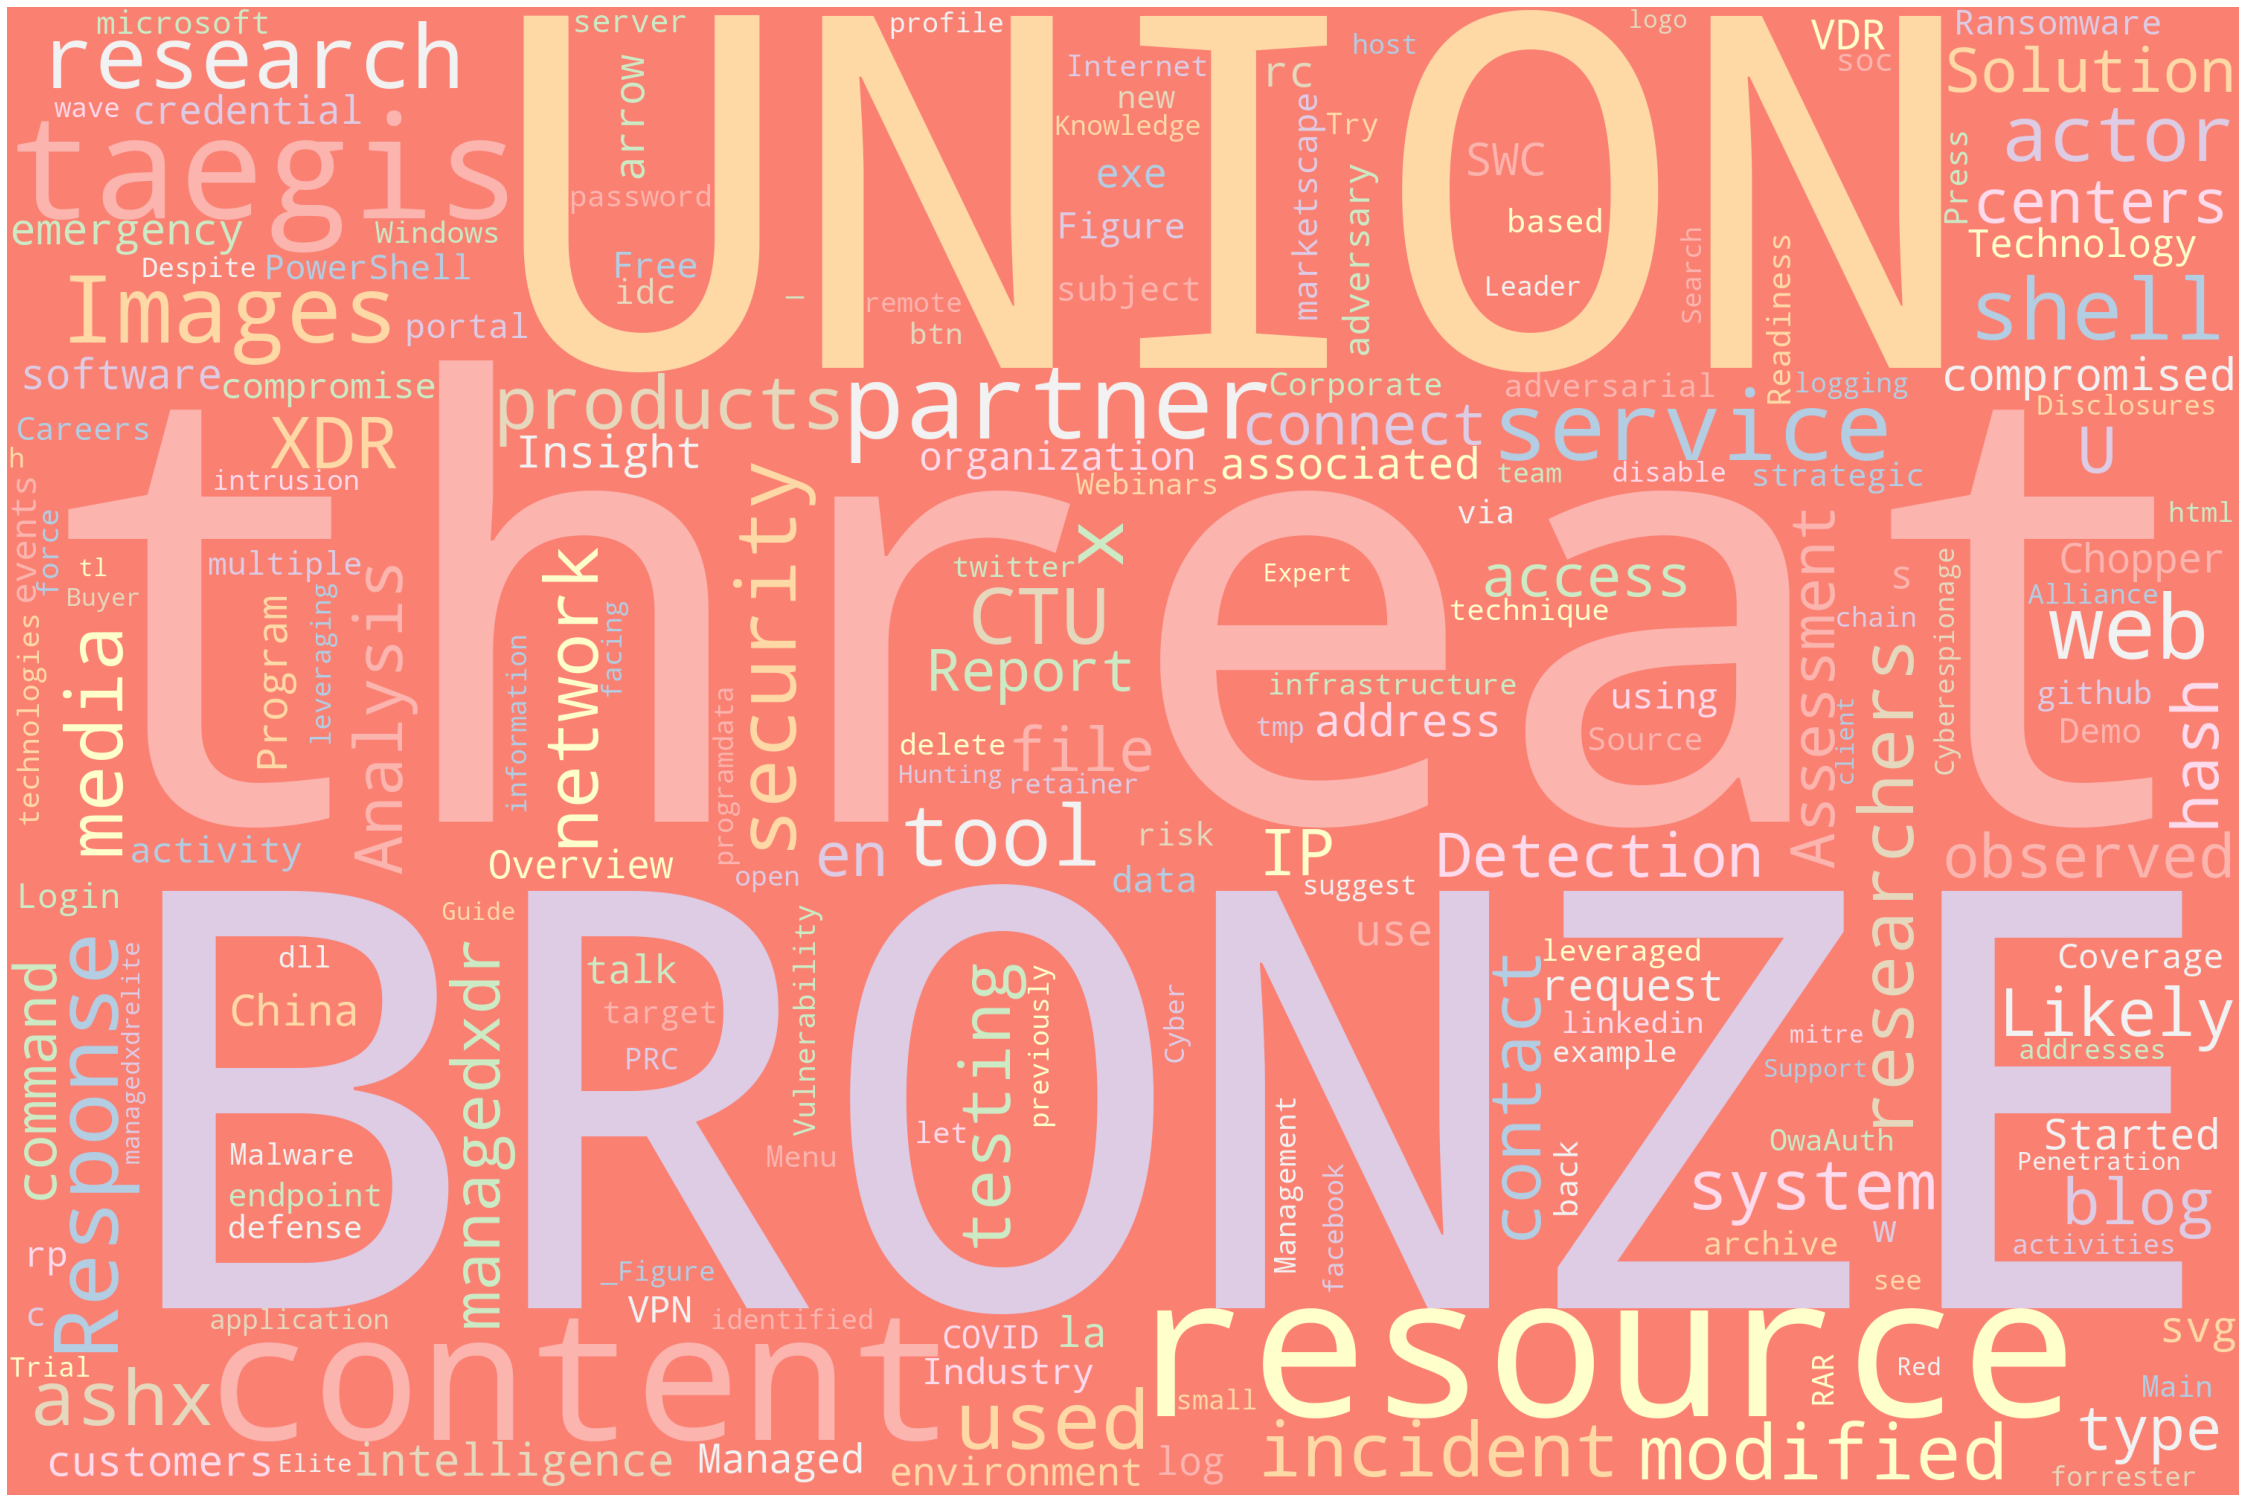

In [46]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords_custom = ["category", "wikipedia", "wiki", "secureworks", "securelist", "https", "Fireeye", "group", "php"] + list(STOPWORDS)

print("[+] Generating Wordcloud...")

wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stopwords_custom).generate(article_text)

# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");

### Cluster APT data via Carrot2

In [47]:
from urllib.parse import urlencode
import requests

query = requests.utils.requote_uri(search_apt)
query

from IPython.display import IFrame

IFrame('https://search.carrot2.org/#/search/web/' + query + '/treemap', width="1600", height="800")

### Search APT in ATT&CK

In [48]:
from stix2 import Filter

def get_group_by_alias(thesrc, alias):
    return thesrc.query([
        Filter('type', '=', 'intrusion-set'),
        Filter('aliases', '=', alias)
    ])[0]

try:
    apt_data = get_group_by_alias(src, search_apt)
    apt_intrusion_set = src.get(apt_data.id)
    mitre_url = apt_data.external_references[0].url
except:
    print("Given APT not found!")

### ATT&CK Techniques

In [52]:
print(apt_data.description)
print("\nCreated: ",apt_data.created)
print('\nURL: ', mitre_url)

[Threat Group-3390](https://attack.mitre.org/groups/G0027) is a Chinese threat group that has extensively used strategic Web compromises to target victims. (Citation: Dell TG-3390) The group has been active since at least 2010 and has targeted organizations in the aerospace, government, defense, technology, energy, and manufacturing sectors. (Citation: SecureWorks BRONZE UNION June 2017) (Citation: Securelist LuckyMouse June 2018)

Created:  2017-05-31 21:31:58.518000+00:00

URL:  https://attack.mitre.org/groups/G0027


In [53]:
import pandas as pd

ttps = []
for r in src.relationships(apt_intrusion_set, 'uses', source_only=True):
    ttp_id = src.get(r.target_ref).external_references[0].external_id
    ttp_name = src.get(r.target_ref).name
    ttp_url = src.get(r.target_ref).external_references[0].url
    ttp = {
        'ID' : ttp_id,
        'Name' : ttp_name,
        'URL' : ttp_url
    }
    ttps.append(ttp)

# pd.set_option('display.max_rows', None)
df = pd.DataFrame.from_dict(ttps)
df.style.set_caption("ATT&CK Techniques")
df

,ID,Name,URL
0,T1018,Remote System Discovery,https://attack.mitre.org/techniques/T1018
1,T1087.001,Local Account,https://attack.mitre.org/techniques/T1087/001
2,S0072,OwaAuth,https://attack.mitre.org/software/S0072
3,T1105,Ingress Tool Transfer,https://attack.mitre.org/techniques/T1105
4,T1560.002,Archive via Library,https://attack.mitre.org/techniques/T1560/002
5,T1574.001,DLL Search Order Hijacking,https://attack.mitre.org/techniques/T1574/001
6,T1071.001,Web Protocols,https://attack.mitre.org/techniques/T1071/001
7,S0039,Net,https://attack.mitre.org/software/S0039
8,T1059.001,PowerShell,https://attack.mitre.org/techniques/T1059/001
9,T1574.002,DLL Side-Loading,https://attack.mitre.org/techniques/T1574/002
